## GMSNetのモデルを作成する  train,eval,test のデータに分ける
### 損失関数の求め方、必要な値が正しく得られているかなど検証してみる
2024/5/17 時点での完成版

コードをすべて問題なく実行できるようにはなった。
最適化されたメッシュを取り出してくることもでき、しっかり更新できている。
しかし、損失の値が全く減少せず、むしろ増加していてほぼもともとのメッシュのままの出力が最適化メッシュとして出てきてしまう。
ゆえに、最適化できているとは到底言えない。






・各epoch後のメッシュの表示


・学習率を0.1倍から0.95倍にしてみる

・シフト切り捨ては推論時飲み使用する

・バッチサイズを変えてみる

・モデルの出力を0.5倍するなどして移動量を小さくする

・学習時はMetricLossで、最適メッシュを選定するときは違う関数なのはなんで

# シフト切り捨てをやめてみる
# トレーニング完了後のトレーニングメッシュを表示してみる
# 各epochの終了時にメッシュを可視化してみる

In [43]:
import copy
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv
from torch_geometric.nn.norm import GraphNorm
import torch_geometric.transforms as T
from torch.nn import Linear, InstanceNorm2d, InstanceNorm1d, Conv1d, ReLU, Tanh
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
from torch_geometric.transforms import FaceToEdge
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from itertools import combinations
import vtk
import glob
from torch_scatter import scatter_mean
from tqdm import tqdm
# 計算を軽くするためのライブラリ
from torch.cuda import empty_cache
import gc               # メモリリークを防ぐ

from torch import nn
import os
import sys

In [44]:
torch.cuda.is_available()

True

In [45]:
num_train_epoch = 50
num_test_epoch = 100
num_trial = 2

# Dataの準備

In [46]:
class Dataset(Dataset):
    def __init__(self, num_files):
        None

class Mesh(Dataset):
    def __init__(self):
        self.coordinates = None
        self.faces = None

class Polygon(Dataset):
    def __init__(self, num_node, num_face):
        self.parent_meshID = None
        self.coordinates = torch.zeros(num_node, 2)
        self.faces = torch.zeros(num_face, 3)
        self.edges = None
        self.d = None
        self.Cx = None
        self.Cy = None
        self.x_min = None
        self.y_min = None

class PolygonID(Dataset):
    def __init__(self, nodeID):
        self.nodeID = nodeID
        # self.parent_meshID = None

class Polygon_data(Dataset):
    def __init__(self, polygonID, meshID, nodeID):
        self.polygonID = polygonID
        self.meshID = meshID
        self.nodeID = nodeID

class Minibatch(Dataset):
    def __init__(self):
        self.x = None
        self.edge_index = None
        self.batch = None

In [47]:
def create_mesh_polygonID_data(vtk_file_path, polygonID_list, poly_count, polygon_dict, mesh_index):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()

    data = reader.GetOutput()
    
    mesh = Mesh()
    # 座標情報を取得
    points = data.GetPoints()
    num_points = points.GetNumberOfPoints()
    coordinates = torch.zeros(num_points, 3)
    for i in range(num_points):
        coordinates[i] = torch.tensor(points.GetPoint(i))

    mesh.coordinates = coordinates[:, :2]                        # mesh.coordinates を定義

    # 面情報を取得
    polys = data.GetPolys()
    num_polys = polys.GetNumberOfCells()
    mesh.faces = torch.zeros(num_polys, 3, dtype=int)           # mesh.faces を定義

    # 各三角形の情報を取得
    polys.InitTraversal()
    for i in range(num_polys):
        cell = vtk.vtkIdList()
        if polys.GetNextCell(cell) == 0:
            break
        mesh.faces[i] = torch.tensor([cell.GetId(0), cell.GetId(1), cell.GetId(2)])
        
# ------------ mesh のデータを取得完了 -------------------------


    # 各セルの各辺の隣接セル数を調べる
    edge_neighbors = {}
    num_cells = data.GetNumberOfCells()
    for cell_index in range(num_cells):
        cell = data.GetCell(cell_index)
        num_edges = cell.GetNumberOfEdges()

        for edge_index in range(num_edges):
            edge = cell.GetEdge(edge_index)
            edge_points = edge.GetPointIds()

            # 辺を構成する点のインデックスを取得
            point1_id = edge_points.GetId(0)
            point2_id = edge_points.GetId(1)

            # 辺を構成する点のインデックスを照準にソート
            edge_key = (min(point1_id, point2_id), max(point1_id, point2_id))

            # 辺の隣接セル数をカウント
            if edge_key in edge_neighbors:
                edge_neighbors[edge_key] += 1
            else:
                edge_neighbors[edge_key] = 1 

    boundary_edges = []
    # 境界上の辺を特定
    for edge_key, num_neighbors in edge_neighbors.items():
        if num_neighbors == 1:
            boundary_edges.append(edge_key)

    # 境界上の辺を構成する頂点の番号を取得
    boundary_points = set()     # 集合を表すデータ型、順番を持たず、重複した要素は取り除かれる
# ---------------- 自由点かどうかの判定完了 ------------------------
    

    for edge_key in boundary_edges:
        boundary_points.add(edge_key[0])
        boundary_points.add(edge_key[1])
    
    
    for pointId in range(num_points):       # pointId:自由点の頂点番号
        if pointId in boundary_points:
            continue
        else:
            poly_count += 1
            # print("pointId:", pointId)
        mask = (mesh.faces == pointId)
        if mask.any():
            count = torch.sum(mask).item()
        num_node = count + 1
        num_face = count
        polygon_number = poly_count - 1 



        
        polygon_i = f"polygon_{polygon_number}"
        # print(polygon_i)
        polygon_i = Polygon(num_node, num_face)
        
        element_to_check = pointId
        polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]
        # print(polygon_i.face)

        polygon_i.nodeId = set()
        for i in range(len(polygon_i.face)):
            polygon_i.nodeId.add(polygon_i.face[i, 0].item())
            polygon_i.nodeId.add(polygon_i.face[i, 1].item())
            polygon_i.nodeId.add(polygon_i.face[i, 2].item())
        sorted_nodeId = sorted(polygon_i.nodeId)
        polygon_i.nodeID = torch.tensor(list(sorted_nodeId))
        
        point_id_index = (polygon_i.nodeID == pointId).nonzero().item()

        value_to_move = polygon_i.nodeID[point_id_index]
        polygon_i.nodeID = torch.cat((value_to_move.unsqueeze(0), polygon_i.nodeID[polygon_i.nodeID != pointId]))
        # print(polygon_i.nodeID)
        setattr(polygon_i, "parent_meshID", mesh)
        polygonID_list.append(f"polygon_{polygon_number}")

        keyword = f"polygon_{polygon_number}"
        valiables = (f"mesh_{mesh_index}", polygon_i.nodeID)
        polygon_dict[keyword] = valiables

    # --------- polygon.nodeID の取得完了 -------------
    return mesh, polygonID_list, poly_count, polygon_dict

# Dataset の作成

In [48]:
def create_mesh_polygon_dataset(vtk_files):
    num_vtk_files = len(vtk_files)
    polygonID_list = []
    mesh_data_list = []
    poly_count = 0
    polygon_dict = {}
    # ファイルに順にアクセスする
    for i in range(num_vtk_files):
        # print("File Name:", vtk_files[i])
        mesh, polygonID_list, poly_count, polygon_dict = create_mesh_polygonID_data(vtk_files[i], polygonID_list, poly_count, polygon_dict, i)
        mesh_data_list.append(mesh)
    return mesh_data_list, polygonID_list, polygon_dict


In [49]:
# 以下、i はpolygon番号で座標と面情報を取得することができる
face_to_edge = T.FaceToEdge(remove_faces=False)
def data_getter(polygonID, num_mesh_data_list, mesh_data_list, polygon_data_list):
    
    polygon_meshID = int(polygon_data_list[polygonID].meshID.split("_")[-1])
    mesh = mesh_data_list[polygon_meshID]
    
    num_node = len(polygon_data_list[polygonID].nodeID)
    num_face = num_node - 1 
    polygon_i = Polygon(num_node, num_face)

    # print(polygon_data_list[polygonID].nodeID)      # polygon に属する頂点の番号

    polygon_i.coordinates = mesh.coordinates[polygon_data_list[polygonID].nodeID]     # polygonの座標
    # print(polygon_i.coordinates)

    # print(polygon_i.faces)

    # polygon_i.faces を取得するコード
    
    element_to_check = polygon_data_list[polygonID].nodeID[0]
    polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]

    indices = torch.nonzero(torch.isin(polygon_i.face, polygon_data_list[polygonID].nodeID))
    for idx in range(indices.size(0)):
        row_idx, col_idx = indices[idx]
        value_to_replace = polygon_i.face[row_idx, col_idx]
        polygon_i.face[row_idx, col_idx] = (polygon_data_list[polygonID].nodeID == value_to_replace).nonzero().item()
    polygon_i.faces = polygon_i.face.long()

    # 各行の三角形からエッジを抽出してedge_indexを構築
    edges = torch.cat([ polygon_i.faces[:, [0, 1]],
                        polygon_i.faces[:, [1, 2]],
                        polygon_i.faces[:, [2, 0]]], dim=0)

    # エッジのインデックスをソートして重複を削除
    edge_index = torch.sort(edges, dim=1).values
    edge_index = torch.tensor(sorted(edge_index.numpy().tolist())).unique(dim=0)
    polygon_i.edge_index = torch.transpose(edge_index, 0, 1)
    return polygon_i



# メッシュをプロットする関数

In [50]:
def plot_mesh(mesh, title):

    vertices = mesh.coordinates
    faces = mesh.faces
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect="equal")

    # 描画するメッシュの頂点をプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'bo')  # 頂点を青色の点でプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'k-')  # 辺を黒色の線でプロット

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        v0_np = v0.detach().numpy()
        v1_np = v1.detach().numpy()
        v2_np = v2.detach().numpy()
        ax.plot([v0_np[0], v1_np[0], v2_np[0], v0_np[0]], [v0_np[1], v1_np[1], v2_np[1], v0_np[1]], 'b-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.001)
    ax.axvline(0, color="black", linewidth=0.001)

    # plt.xlim(-300, 150)
    # plt.ylim(-200, 1400)
    # plt.savefig(f"/mnt/{title}.png", format="png")
    plt.show()
    plt.close()


In [51]:
def save_mesh(mesh, title):

    vertices = mesh.coordinates
    faces = mesh.faces
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect="equal")

    # 描画するメッシュの頂点をプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'bo')  # 頂点を青色の点でプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'k-')  # 辺を黒色の線でプロット

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        v0_np = v0.detach().numpy()
        v1_np = v1.detach().numpy()
        v2_np = v2.detach().numpy()
        ax.plot([v0_np[0], v1_np[0], v2_np[0], v0_np[0]], [v0_np[1], v1_np[1], v2_np[1], v0_np[1]], 'b-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.001)
    ax.axvline(0, color="black", linewidth=0.001)

    # plt.xlim(-300, 150)
    # plt.ylim(-200, 1400)
    plt.savefig(f"/mnt/Saved_mesh2/{title}.png", format="png")
    # plt.show()
    plt.close()

# meshデータからvtkファイルを出力する関数

In [52]:
def vtk_output(mesh, title):
    vertices = mesh.coordinates
    faces = mesh.faces
    num_vertices = len(vertices)
    num_faces = len(faces)


    # vertices を３次元に戻す
    z_column = torch.zeros(vertices.shape[0], 1)
    vertices = torch.cat((vertices, z_column), dim=1)

    with open(f"/mnt/optimized_data/{title}.vtk", "w") as f:
        f.write("# vtk DataFile Version 2.0\n")
        f.write("FOR TEST\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")

        f.write("POINTS {} float\n".format(num_vertices))
        for vertex in vertices:
            f.write("{:.15f} {:.15f} {:.15f}\n".format(*vertex))

        f.write("\nPOLYGONS {} {}\n".format(num_faces, num_faces * 4))
        for face in faces:
            f.write("3 ")
            f.write(" ".join(str(idx.item()) for idx in face))
            f.write("\n")
       



# Normalization

In [53]:
def normalization(polygon):
    vertices = polygon.coordinates
    normalized_vertices = vertices.clone()
    centered_vertices = vertices.clone()
    # print(vertices)

    max_x = torch.max(vertices[:,0])
    min_x = torch.min(vertices[:,0])
    max_y = torch.max(vertices[:,1])
    min_y = torch.min(vertices[:,1])

    polygon.d = torch.max(max_x - min_x, max_y - min_y)
    polygon.x_min = min_x
    polygon.y_min = min_y

    normalized_vertices = (vertices - torch.tensor([polygon.x_min, polygon.y_min])) / polygon.d

    
    polygon.Cx = normalized_vertices[0,0].item()
    polygon.Cy = normalized_vertices[0,1].item()   

    centered_vertices = normalized_vertices - torch.tensor([polygon.Cx, polygon.Cy])
    polygon.coordinates = centered_vertices
    
    # print("Normalized polygon:", vertices)

    return polygon


    


# denormalization

In [54]:
def denormalization(polygon):
    vertices = polygon.coordinates
    shifted_vertices = vertices.clone()
    denormalized_vertices = vertices.clone()
    
    shifted_vertices = vertices + torch.tensor([polygon.Cx, polygon.Cy])
        

    denormalized_vertices = polygon.d * shifted_vertices + torch.tensor([polygon.x_min, polygon.y_min])
    polygon.coordinates = denormalized_vertices
    return polygon


# MetricLoss

In [55]:
import sys

import logging

logging.basicConfig(
    filename='metric_loss.log',
    level=logging.DEBUG, 
    format='%(message)s'
)

logger = logging.getLogger(__name__)

class MetricLoss:
    def select_vertices(self, vertices, face):
        v0 = vertices[face[0]].clone()
        v1 = vertices[face[1]].clone()
        v2 = vertices[face[2]].clone()
        return v0, v1, v2 

    def edge_length(self, v0, v1, v2):
        l1 = torch.sqrt((v0[0] - v1[0])**2 + (v0[1] - v1[1])**2)
        l2 = torch.sqrt((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)
        l3 = torch.sqrt((v2[0] - v0[0])**2 + (v2[1] - v0[1])**2)

        return l1, l2, l3

    def face_area(self, polygon, l1, l2, l3):
        
        s = 0.5*(l1 + l2 + l3)
        #print(round(l1.item(),5), round(l2.item(),5), round(l3.item(),5), round(s.item(),5), round((s*(s-l1)*(s-l2)*(s-l3)).item(),5))
        temp = s*(s-l1)*(s-l2)*(s-l3)
        #temp.register_hook(print_grad)
        logger.info("    s, in_sqrt: {}, {}".format(s.item(), temp.item()))
        
        try:
            
            face_area = torch.sqrt(temp)
            
        except Exception as e:
            
            SimplePolygonGenerator.polygon_visualizer(polygon)
            
            print("An error occurred")
            print("Value of temp:", temp)
            print(l1.item(), l2.item(), l3.item())
            
            raise
        
        #face_area = torch.sqrt(temp)
        #face_area.register_hook(print_grad)
        return face_area

    def compute_loss(self, polygon, vertices, face, dx):
        v0, v1, v2 = self.select_vertices(vertices, face)
        if dx is not None:
            if face[0]==0:
                v0 = v0 + dx
            elif face[1]==0:
                v1 += v1 + dx
            elif face[2]==0:
                v2 += v2 + dx
        #print(v0, v1, v2)
        logger.info("    v0: ({}, {})".format(v0[0].item(), v0[1].item()))
        logger.info("    v1: ({}, {})".format(v1[0].item(), v1[1].item()))
        logger.info("    v2: ({}, {})".format(v2[0].item(), v2[1].item()))
        l1, l2, l3 = self.edge_length(v0, v1, v2)
        logger.info("    l1, l2, l3:  {}, {}, {}".format(l1.item(), l2.item(), l3.item()))
        s = self.face_area(polygon, l1, l2, l3)
        #print(s.item(), l1.item(), l2.item(), l3.item())

        #q = (l1**2 + l2**2 + l3**2)/(4.0*torch.sqrt(torch.tensor(3.))*s+1.0)
        
        #loss = 1 - 1/q
        #print(q.item(), loss.item())
        
        #q = q.clone().detach().requires_grad_(True)
        loss = 1-(4.0*torch.sqrt(torch.tensor(3.))*s)/(l1**2 + l2**2 + l3**2)
        logger.info("    area, loss: {}, {}".format(s.item(), loss.item()))
        logger.info("")
        #print(loss.item())
        #print("")
        
        #loss.register_hook(print_grad)
        
        return loss

    def __call__(self, polygon, dx=None):
        vertices = polygon.coordinates
        faces = polygon.faces
        loss = 0 
        #print(vertices)
        #print(dx)
        for face in faces:
            loss = loss + self.compute_loss(polygon, vertices, face, dx)
        
        metric_loss = loss/(len(polygon.coordinates[:,0])-1) #.clone().detach().requires_grad_(True))
        return metric_loss
    
    
def print_grad(grad):
    print(grad)

# meshデータからq_hatを求める関数

In [56]:
def calculate_q_hat(mesh):
    vertices = mesh.coordinates
    faces = mesh.faces
    r_list = []
    alpha_list = []
    beta_list = []

    for face in faces:
        # a(最小角)と b(最大角)を求める

        angles = []
        v0, v1, v2 = m_loss.select_vertices(vertices, face)
        l1, l2, l3 = m_loss.edge_length(v0, v1, v2)

        # 余弦定理から各角度の余弦値を計算
        cos_alpha = (l2**2 + l3**2 - l1**2) / (2*l2*l3)
        cos_beta = (l1**2 + l3**2 - l2**2) / (2*l1*l3)
        cos_gamma = (l1**2 + l2**2 - l3**2) / (2*l1*l2)
        # 余弦値から角度を計算して個度法に変換
        alpha = torch.acos(cos_alpha) * 180 / np.pi
        beta = torch.acos(cos_beta) * 180 / np.pi
        gamma = torch.acos(cos_gamma) * 180 / np.pi

        angles.append(alpha)
        angles.append(beta)
        angles.append(gamma)

        min_angle = min(angles)
        max_angle = max(angles)

        alpha_list.append(min_angle)
        beta_list.append(max_angle)



        # 1/q = r を求める

        r = 1 - m_loss.compute_loss(vertices, face) 
        r_list.append(r)

    a_mean = sum(alpha_list) / len(alpha_list)
    a_min = min(alpha_list)
    b_mean = sum(beta_list) / len(beta_list)
    b_max = max(beta_list)
    r_mean = sum(r_list) / len(r_list)
    r_min = min(r_list)

    q_hat = (((a_mean + a_min + 120 - b_max - b_mean)/60) + r_mean + r_min) / 6

    return q_hat

    


    
    

スターポリゴンの中から外側に自由点が移動したときに自由点の移動量を半分にしてもう一度外に行っていないか検証する
自由点が外に行かないことを確認したあとのスターポリゴンを返す

In [57]:
def check(polygon, polygonID):
    # print("polygonID:", polygonID)
    vertices = polygon.coordinates
    
    edge_index = polygon.edge_index
    
    return_value = True
    while return_value == True:   

        for i in range(1, len(vertices[:,0])):
            point1 = torch.tensor([0.0, 0.0])
            point2 = vertices[0]
            point3 = vertices[i]
            
            pos_i = torch.where(edge_index[0] == i)
            pos_i = pos_i[0]
            # print("edge_index[0]", edge_index[0])
            
            for j in range(len(pos_i)):
                if edge_index[1, pos_i[j]] == 0:
                    continue
                else:
                    val_pos_i = edge_index[1, pos_i[j]]
                    break

            point4 = vertices[val_pos_i]


            a1 = 0
            b1 = 0
            a2 = 0
            b2 = 0
            check1 = 0
            check2 = 0
            check3 = 0
            check4 = 0
            x1 = point1[0]
            y1 = point1[1]
            x2 = point2[0]
            y2 = point2[1]
            x3 = point3[0]
            y3 = point3[1]
            x4 = point4[0]
            y4 = point4[1]
            a1 = (y1 - y2)/(x1-x2)
            b1 = y1 - (a1*x1)
            a2 = (y3 - y4)/(x3-x4)
            b2 = y3 - (a2*x3)
            check1 = (a1*x3) - y3 + b1 
            check2 = (a1*x4) - y4 + b1    # point1,2を通る直線に対してpoint3,4を結ぶ線分が交差しているか
            check3 = (a2*x1) - y1 + b2
            check4 = (a2*x2) - y2 + b2    # point3,4を通る直線に対してpoint1,2を結ぶ線分が交差しているか
            # print("1:",check1,"2:",check2,"3:",check3,"4:",check4)
            del a1, a2, b1, b2, x1, x2, x3, x4, y1, y2, y3, y4 

            if (check1*check2) <= 0 and (check3*check4) <= 0 :
                return_value = True
                # print("Out_of_StarPolygon")
                vertices[0] = 0.5*vertices[0]
                polygon.coordinates[0] = vertices[0]
                break
            else:
                return_value = False
                continue       
            
        
    # plot_mesh(polygon, "polygon_checked")
               
    return polygon

# Model 隠れ層のノード数は何にするか未定

In [58]:
class GMSNet(torch.nn.Module):
    
    def __init__(self, input_dim, feature_dim, hidden_channnels):
        
        super(GMSNet, self).__init__()
        torch.manual_seed(42)
        
        self.shared_mlp = Conv1d(input_dim, feature_dim, kernel_size=1)
        self.GNorm = GraphNorm(feature_dim, feature_dim)
        self.conv = GCNConv(feature_dim, feature_dim)
        self.fc1 = Linear(feature_dim, hidden_channnels)
        #self.ISNorm = InstanceNorm1d(hidden_channnels, affine=True)
        self.fc2 = Linear(hidden_channnels, input_dim)
        
        self.relu = ReLU()
        self.tanh = Tanh()

        # Weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv1d)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x, edge_index):       
        
        # feature
        x = torch.permute(x, (0, 2, 1))
        x = self.shared_mlp(x)
        feature = self.relu(x)
        feature = torch.permute(feature, (0, 2, 1))
        
        # GNN
        x = self.GNorm(feature)
        x = self.relu(x)
        gnn_feature = self.conv(x, edge_index) + feature
        
        # MLP
        target_feature = gnn_feature.mean(dim=1)
        mlp_midlayer = self.fc1(target_feature)
        x = self.relu(mlp_midlayer)
        x = self.fc2(x)
        x = self.tanh(x)
        
        x = 0.1*x
        
        return x

# Main

In [59]:
# フォルダ内のすべてのvtkファイルにアクセスする
train_vtk_files = glob.glob("/mnt/Train_Data/*.vtk")
eval_vtk_files = glob.glob("/mnt/Eval_Data/*.vtk")
test_vtk_files = glob.glob("/mnt/Test_Data/*vtk")

num_train_mesh = len(train_vtk_files)
num_test_mesh = len(test_vtk_files)
print("num_train_mesh:", num_train_mesh)
train_mesh_data_list, train_polygonID_list, train_polygon_dict = create_mesh_polygon_dataset(train_vtk_files)
eval_mesh_data_list, eval_polygonID_list, eval_polygon_dict = create_mesh_polygon_dataset(eval_vtk_files)
test_mesh_data_list, test_polygonID_list, test_polygon_dict = create_mesh_polygon_dataset(test_vtk_files)


    
# ポリゴンデータを格納するリストを作成
train_polygon_data_list = []
eval_polygon_data_list = []
test_polygon_data_list = []

for i in range(len(train_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = train_polygon_dict[f"polygon_{i}"][0]
    nodeID = train_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    train_polygon_data_list.append(polygon_data)

for i in range(len(eval_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = eval_polygon_dict[f"polygon_{i}"][0]
    nodeID = eval_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    eval_polygon_data_list.append(polygon_data)

for i in range(len(test_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = test_polygon_dict[f"polygon_{i}"][0]
    nodeID = test_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    test_polygon_data_list.append(polygon_data)

num_train_mesh: 1


In [60]:
type(train_polygon_data_list[0])

__main__.Polygon_data

In [61]:
train_data_loader = DataLoader(train_polygonID_list, batch_size=64*num_train_mesh, shuffle=True)
# eval_data_loader = DataLoader(eval_polygonID_list, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_polygonID_list, batch_size=64*num_test_mesh, shuffle=True)
# for step, data in enumerate(data_loader):
#     print(f"Step {step + 1}:")
#     print("==========")
#     print(data)
#     print(len(data))
#     for i in range(len(data)):
#         polygonID = int(data[i].split("_")[-1])
#         print("polygonID:",polygonID)
#         polygon = data_getter(polygonID, 0)
#         print("polygon.coordinates:",polygon.coordinates)
#         print("polygon.edge_index:", polygon.edge_index)
#         print("==========")
#         # plot_mesh(polygon, "title")

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GMSNet(input_dim=2, feature_dim=64, hidden_channnels=64)
model.to(device)
print(model)
m_loss = MetricLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
criterion = MetricLoss()
#criterion = nn.MSELoss()

cuda
GMSNet(
  (shared_mlp): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
  (GNorm): GraphNorm(64)
  (conv): GCNConv(64, 64)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)


In [63]:
model.load_state_dict(torch.load('mnt/model_weight.pth'))

<All keys matched successfully>

In [64]:
writer = SummaryWriter("logs")
# 学習率を調整するスケジューラの設定
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.95, verbose=True)

loss_list = []

def train_(device):
    model.train()
    loss_list = []
    for step, data in enumerate(train_data_loader):
        empty_cache()
        gc.collect()
        # print(f"Step {step + 1}:")
        # print("==========")
        # print(data)
        # print(len(data))
        minibatch = Minibatch()
        minibatch_coordinates = []
        all_edge_index_1 = []
        all_edge_index_2 = []
        batch_list = []
        num_dis = 0
        metric_loss_list = []
        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            # print("polygonID:",polygonID)
            polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)                                                                     # 270MiB
            # plot_mesh(polygon, "")      #############################################

            # polygon を正規化する
            polygon = normalization(polygon)                                                                        # 900MiB
            
            # plot_mesh(polygon, "")      #############################################

            # print("polygon.coordinates:",polygon.coordinates)
            edge_index = polygon.edge_index + num_dis                               
            # print("polygon.edge_index:", edge_index)
            all_edge_index_1.append(edge_index[0])
            all_edge_index_2.append(edge_index[1])
            num_dis = num_dis + len(polygon.coordinates)
            # print("==========")
            minibatch_coordinates.append(polygon.coordinates)
            batch_i = torch.tensor([i]*len(polygon.coordinates))                    
            batch_list.append(batch_i)
            
        # print(minibatch_coordinates)
        minibatch.x = torch.cat(minibatch_coordinates, dim=0)
        
        # print(minibatch.x)
        # print("minibatch.x.size:", minibatch.x.size())
        edge_index_1 = torch.cat(all_edge_index_1, dim=-1)
        edge_index_2 = torch.cat(all_edge_index_2, dim=-1)
        minibatch.edge_index = torch.cat([edge_index_1.unsqueeze(0), edge_index_2.unsqueeze(0)], dim=0)
        # print(minibatch.edge_index)
        # print("minibatch.edge_index.size:", minibatch.edge_index.size())
        minibatch.batch = torch.cat(batch_list, dim=0)
        # print(minibatch.batch)
        # print("minibatch.batch.size:", minibatch.batch.size())

        # すべてのデータをGPU上に移動する
        minibatch.x = minibatch.x.to(device)
        minibatch.edge_index = minibatch.edge_index.to(device)
        minibatch.batch = minibatch.batch.to(device)
        model.to(device)

        out = model(minibatch.x, minibatch.edge_index)                                     # 333MiB
        # print("out:", out)
        # print("out:", out.size())

        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)                                                             # 225MiB
            polygon = normalization(polygon)                                                                # 932MiB

            metric_loss = criterion(polygon)
            metric_loss = criterion(polygon, out[i].cpu())
            
            polygon.coordinates[0] = out[i]

            metric_loss_list.append(metric_loss)

        loss = (sum(metric_loss_list) / len(metric_loss_list))      # .requires_grad_(True)
        print("Loss:", loss)
        writer.add_scalar("Loss/train", loss, epoch)
        # print("loss:", loss)

        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            for i in range(len(data)):
                # gc.collect()
                polygonID = int(data[i].split("_")[-1])
                polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)                                                             # 225MiB
                polygon = normalization(polygon)    
                
                polygon.coordinates[0] = polygon.coordinates[0] + out[i]
                
                polygon_meshID = int(train_polygon_data_list[polygonID].meshID.split("_")[-1])
                mesh = train_mesh_data_list[polygon_meshID]

                mesh.coordinates[train_polygon_data_list[polygonID].nodeID[0]] = polygon.coordinates[0]
        
        del out
        
        loss.detach()               # 計算グラフを切り離し、不要な計算グラフが保持されることを防ぐ
        optimizer.zero_grad()

        # ステップごとに損失をログに記録
        writer.add_scalar("/mnt/logs", loss.item(), global_step=len(train_data_loader)*epoch + step)

        loss_list.append(loss.item())
    
    val_loss = sum(loss_list)/ len(loss_list)
    scheduler.step(val_loss)


def train(device):
    model.train()
    model.to(device)
    
    temp = 0
    ddd = 0
    
    for step, data in enumerate(train_data_loader):
        
        optimizer.zero_grad()
        metric_loss = 0
        dx_list = []
        
        for i in range(len(data)):

            polygonID = int(data[i].split("_")[-1])
            polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)
            polygon = normalization(polygon) 

            edge_index = polygon.edge_index               
            
            x = polygon.coordinates.clone().unsqueeze(0).to(device)
            ei = edge_index.to(device)
            out = model(x, ei)
            
            logger.info("epoch: {:04}, polygonID: {:04}".format(epoch, polygonID))
            logger.info("before")
            with torch.no_grad():
                ml = criterion(polygon)
                logger.info("")
            logger.info("after")
            l = criterion(polygon, out[0].cpu())
            
            logger.info("")
            
            metric_loss += l
            dx_list.append(out[0].cpu())
                
            #prediction_list[polygonID].append(out[0].cpu())
            
        loss = metric_loss/len(data)
        ddd += len(data)
        temp += loss
        print("    Loss:", loss.item(), polygonID)
        
        loss.backward()
        optimizer.step()
        
        #if epoch>10:
        for i in range(len(data)):

            with torch.no_grad():
                polygonID = int(data[i].split("_")[-1])

                polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)
                polygon = normalization(polygon) 

                polygon.coordinates[0] = polygon.coordinates[0] + dx_list[i]
                polygon = denormalization(polygon)
                
                polygon_meshID = int(train_polygon_data_list[polygonID].meshID.split("_")[-1])
                mesh = train_mesh_data_list[polygon_meshID]
                mesh.coordinates[train_polygon_data_list[polygonID].nodeID[0]] = polygon.coordinates[0]

            #print()
            
    loss_list.append(temp/ddd)

# 最終的な最適化したメッシュを生成してvtkファイルで出力する

In [65]:
# TensorBoard用のログディレクトリを指定
writer = SummaryWriter("/mnt/logs")
epoch = 0

import torch
torch.autograd.set_detect_anomaly(True)

for j in range(num_train_mesh):
        save_mesh(train_mesh_data_list[j], f"{epoch}_{j}")

for epoch in tqdm(range(num_train_epoch)):
    #print("epoch:", epoch)
    train(device)

    # for i in range(num_train_mesh):
    #     plot_mesh(train_mesh_data_list[i], f"{i}")
    for j in range(num_train_mesh):
        save_mesh(train_mesh_data_list[j], f"{epoch+1}_{j}")
    
writer.close()



  0%|          | 0/50 [00:00<?, ?it/s]

    Loss: 0.24135039746761322 149
    Loss: 0.20355500280857086 463
    Loss: 0.1993480920791626 137
    Loss: 0.17992450296878815 436
    Loss: 0.15936806797981262 335
    Loss: 0.13674911856651306 451
    Loss: 0.13232621550559998 272
    Loss: 0.11108976602554321 26


  2%|▏         | 1/50 [00:27<22:51, 27.98s/it]

    Loss: 0.07352583110332489 126
    Loss: 0.07243559509515762 50
    Loss: 0.06179524213075638 263
    Loss: 0.05293716490268707 147
    Loss: 0.05316678062081337 282
    Loss: 0.04038859158754349 117
    Loss: 0.040615569800138474 432
    Loss: 0.027610167860984802 338


  4%|▍         | 2/50 [00:55<22:22, 27.96s/it]

    Loss: 0.025041349232196808 99
    Loss: 0.025571508333086967 344
    Loss: 0.024019839242100716 180
    Loss: 0.01875414326786995 59
    Loss: 0.016407418996095657 223
    Loss: 0.015033119358122349 213
    Loss: 0.013374489732086658 36
    Loss: 0.013951859436929226 379


  6%|▌         | 3/50 [01:23<21:51, 27.90s/it]

    Loss: 0.01175722386687994 458
    Loss: 0.00931243784725666 63
    Loss: 0.012254495173692703 344
    Loss: 0.011367456056177616 278
    Loss: 0.01153855212032795 267
    Loss: 0.010411499068140984 102
    Loss: 0.01017378643155098 392
    Loss: 0.006522120907902718 185


  8%|▊         | 4/50 [01:51<21:20, 27.84s/it]

    Loss: 0.007740807719528675 79
    Loss: 0.00836039986461401 248
    Loss: 0.010274114087224007 237
    Loss: 0.008011925965547562 18
    Loss: 0.008059355430305004 380
    Loss: 0.00706472946330905 352
    Loss: 0.009269317612051964 366
    Loss: 0.006578764878213406 91


 10%|█         | 5/50 [02:19<20:54, 27.89s/it]

    Loss: 0.007362795062363148 302
    Loss: 0.008781992830336094 368
    Loss: 0.006114892661571503 470
    Loss: 0.01004971843212843 212
    Loss: 0.007612924091517925 96
    Loss: 0.007542525418102741 273
    Loss: 0.0052269138395786285 131
    Loss: 0.006077512167394161 144


 12%|█▏        | 6/50 [02:47<20:28, 27.93s/it]

    Loss: 0.006769436877220869 164
    Loss: 0.006396990269422531 280
    Loss: 0.005991053767502308 295
    Loss: 0.007769308984279633 23
    Loss: 0.008119892328977585 195
    Loss: 0.008384127169847488 142
    Loss: 0.0061822677962481976 445
    Loss: 0.00580918975174427 148


 14%|█▍        | 7/50 [03:14<19:44, 27.55s/it]

    Loss: 0.005700263194739819 44
    Loss: 0.008548432029783726 479
    Loss: 0.005056825000792742 220
    Loss: 0.005855269730091095 367
    Loss: 0.007079768925905228 190
    Loss: 0.006213795393705368 80
    Loss: 0.008524887263774872 10
    Loss: 0.006434335373342037 208


 16%|█▌        | 8/50 [03:42<19:23, 27.69s/it]

    Loss: 0.007056636735796928 151
    Loss: 0.006541329901665449 172
    Loss: 0.005536191165447235 90
    Loss: 0.007812855765223503 461
    Loss: 0.007534930482506752 125
    Loss: 0.006322293542325497 373
    Loss: 0.004762333817780018 21
    Loss: 0.00683737313374877 346


 18%|█▊        | 9/50 [04:09<18:50, 27.57s/it]

    Loss: 0.007387867197394371 126
    Loss: 0.005300187971442938 227
    Loss: 0.008132106624543667 371
    Loss: 0.007015197072178125 242
    Loss: 0.005360657814890146 35
    Loss: 0.00643062312155962 287
    Loss: 0.0059357620775699615 34
    Loss: 0.005642148200422525 51


 20%|██        | 10/50 [04:38<18:34, 27.85s/it]

    Loss: 0.004936777055263519 485
    Loss: 0.007004204206168652 418
    Loss: 0.0040082926861941814 209
    Loss: 0.007468454539775848 308
    Loss: 0.007133202627301216 348
    Loss: 0.0045625753700733185 115
    Loss: 0.007777924183756113 142
    Loss: 0.008373098447918892 421


 22%|██▏       | 11/50 [05:04<17:51, 27.47s/it]

    Loss: 0.006629450712352991 430
    Loss: 0.0071769943460822105 94
    Loss: 0.008109424263238907 161
    Loss: 0.005766445305198431 346
    Loss: 0.006563771050423384 240
    Loss: 0.0046025109477341175 120
    Loss: 0.0067853182554244995 171
    Loss: 0.0038432462606579065 213


 24%|██▍       | 12/50 [05:33<17:35, 27.78s/it]

    Loss: 0.007193050347268581 81
    Loss: 0.007204851601272821 266
    Loss: 0.006832352373749018 42
    Loss: 0.005089346785098314 311
    Loss: 0.005343465134501457 375
    Loss: 0.005719572305679321 138
    Loss: 0.006941023748368025 478
    Loss: 0.005131727084517479 142


 26%|██▌       | 13/50 [05:59<16:56, 27.47s/it]

    Loss: 0.005600101314485073 428
    Loss: 0.009642095305025578 209
    Loss: 0.0048868125304579735 144
    Loss: 0.0038655272219330072 252
    Loss: 0.00624094158411026 106
    Loss: 0.006414716597646475 203
    Loss: 0.007981689646840096 88
    Loss: 0.0042029176838696 16


 28%|██▊       | 14/50 [06:26<16:19, 27.20s/it]

    Loss: 0.009175579994916916 267
    Loss: 0.0055177598260343075 295
    Loss: 0.005203411914408207 494
    Loss: 0.007319681346416473 213
    Loss: 0.005298939999192953 403
    Loss: 0.005378352478146553 226
    Loss: 0.005550052039325237 252
    Loss: 0.005448296200484037 59


 30%|███       | 15/50 [06:55<16:11, 27.77s/it]

    Loss: 0.004842682275921106 145
    Loss: 0.0036157225258648396 195
    Loss: 0.005830308888107538 228
    Loss: 0.007268826011568308 59
    Loss: 0.007029200904071331 464
    Loss: 0.009430068545043468 119
    Loss: 0.004199432674795389 133
    Loss: 0.0068326545879244804 475


 32%|███▏      | 16/50 [07:22<15:31, 27.38s/it]

    Loss: 0.00478948000818491 275
    Loss: 0.005602792836725712 178
    Loss: 0.006934688426554203 47
    Loss: 0.005634560715407133 26
    Loss: 0.006377992685884237 220
    Loss: 0.007929321378469467 263
    Loss: 0.006693248637020588 406
    Loss: 0.004147867206484079 328


 34%|███▍      | 17/50 [07:48<14:55, 27.14s/it]

    Loss: 0.00658485246822238 82
    Loss: 0.0049561988562345505 370
    Loss: 0.004980846773833036 207
    Loss: 0.005467056762427092 16
    Loss: 0.0067705861292779446 124
    Loss: 0.005131885875016451 57
    Loss: 0.006192565429955721 493
    Loss: 0.009169723838567734 492


 36%|███▌      | 18/50 [08:18<14:52, 27.89s/it]

    Loss: 0.004511207342147827 129
    Loss: 0.0051621305756270885 455
    Loss: 0.00525030167773366 161
    Loss: 0.006048253271728754 244
    Loss: 0.007064547855407 303
    Loss: 0.008351016789674759 297
    Loss: 0.0068434784188866615 114
    Loss: 0.004672451410442591 389


 38%|███▊      | 19/50 [08:45<14:14, 27.57s/it]

    Loss: 0.005759804509580135 296
    Loss: 0.005419991910457611 268
    Loss: 0.007463954389095306 100
    Loss: 0.005682323593646288 81
    Loss: 0.0041435412131249905 343
    Loss: 0.0047497497871518135 325
    Loss: 0.010136269964277744 57
    Loss: 0.004359923303127289 46


 40%|████      | 20/50 [09:11<13:38, 27.30s/it]

    Loss: 0.0055981650948524475 254
    Loss: 0.007371549494564533 133
    Loss: 0.005828243680298328 487
    Loss: 0.004423738922923803 321
    Loss: 0.007484997157007456 38
    Loss: 0.007531288545578718 421
    Loss: 0.00422863382846117 24
    Loss: 0.005422819871455431 61


 42%|████▏     | 21/50 [09:38<13:05, 27.08s/it]

    Loss: 0.008377994410693645 245
    Loss: 0.004549023695290089 151
    Loss: 0.006461349781602621 483
    Loss: 0.006297016981989145 368
    Loss: 0.0073087443597614765 288
    Loss: 0.0042445966973900795 0
    Loss: 0.004920403007417917 147
    Loss: 0.005672142840921879 286


 44%|████▍     | 22/50 [10:04<12:33, 26.93s/it]

    Loss: 0.004299398977309465 379
    Loss: 0.004796606954187155 458
    Loss: 0.009886834770441055 48
    Loss: 0.007350511848926544 44
    Loss: 0.005252957344055176 334
    Loss: 0.005426823627203703 81
    Loss: 0.006192450877279043 79
    Loss: 0.004108530003577471 16


 46%|████▌     | 23/50 [10:35<12:33, 27.92s/it]

    Loss: 0.0057190838269889355 120
    Loss: 0.004656434990465641 165
    Loss: 0.005317599046975374 439
    Loss: 0.005116327665746212 366
    Loss: 0.004595582373440266 313
    Loss: 0.007318190298974514 115
    Loss: 0.006616024300456047 430
    Loss: 0.009281459264457226 446


 48%|████▊     | 24/50 [11:01<11:57, 27.59s/it]

    Loss: 0.0050688148476183414 117
    Loss: 0.0071531119756400585 363
    Loss: 0.00505933677777648 265
    Loss: 0.0049456702545285225 119
    Loss: 0.008194179274141788 32
    Loss: 0.005385230295360088 340
    Loss: 0.005905493162572384 320
    Loss: 0.005949172656983137 158


 50%|█████     | 25/50 [11:28<11:23, 27.33s/it]

    Loss: 0.005570479668676853 97
    Loss: 0.0055160000920295715 270
    Loss: 0.0057790824212133884 228
    Loss: 0.006205783225595951 178
    Loss: 0.0053436290472745895 336
    Loss: 0.006073252763599157 160
    Loss: 0.007239145692437887 486
    Loss: 0.005828455556184053 54


 52%|█████▏    | 26/50 [11:55<10:50, 27.12s/it]

    Loss: 0.005084628239274025 356
    Loss: 0.005534077063202858 60
    Loss: 0.006636493373662233 323
    Loss: 0.007647195365279913 400
    Loss: 0.005822759121656418 93
    Loss: 0.006968226283788681 353
    Loss: 0.0049995663575828075 438
    Loss: 0.004433698020875454 325


 54%|█████▍    | 27/50 [12:22<10:21, 27.00s/it]

    Loss: 0.005460359621793032 198
    Loss: 0.006013629958033562 237
    Loss: 0.005802194122225046 92
    Loss: 0.006656891666352749 444
    Loss: 0.006876929197460413 218
    Loss: 0.006599915213882923 424
    Loss: 0.0045658014714717865 314
    Loss: 0.005326710641384125 223


 56%|█████▌    | 28/50 [12:52<10:19, 28.17s/it]

    Loss: 0.007179909385740757 4
    Loss: 0.0041176797822117805 492
    Loss: 0.0038047702983021736 459
    Loss: 0.006931359879672527 378
    Loss: 0.007647610269486904 163
    Loss: 0.007009326014667749 260
    Loss: 0.006285284645855427 6
    Loss: 0.0038911523297429085 227


 58%|█████▊    | 29/50 [13:19<09:44, 27.84s/it]

    Loss: 0.00660553015768528 385
    Loss: 0.0030801172833889723 253
    Loss: 0.005682077724486589 444
    Loss: 0.004376708064228296 34
    Loss: 0.007439726032316685 312
    Loss: 0.007352751679718494 129
    Loss: 0.005078232381492853 242
    Loss: 0.008409292437136173 441


 60%|██████    | 30/50 [13:46<09:11, 27.58s/it]

    Loss: 0.006232999265193939 245
    Loss: 0.007572297938168049 217
    Loss: 0.006493470165878534 152
    Loss: 0.004736877512186766 82
    Loss: 0.0027581127360463142 37
    Loss: 0.005623881239444017 398
    Loss: 0.009267192333936691 358
    Loss: 0.0041545904241502285 282


 62%|██████▏   | 31/50 [14:13<08:40, 27.38s/it]

    Loss: 0.005802574567496777 74
    Loss: 0.00790463201701641 39
    Loss: 0.004447374027222395 284
    Loss: 0.006221954245120287 4
    Loss: 0.005528225563466549 77
    Loss: 0.008477539755403996 355
    Loss: 0.0028720758855342865 459
    Loss: 0.00605503236874938 465


 64%|██████▍   | 32/50 [14:40<08:10, 27.27s/it]

    Loss: 0.0051340339705348015 131
    Loss: 0.007433790247887373 383
    Loss: 0.004479705356061459 245
    Loss: 0.010034948587417603 302
    Loss: 0.004171562846750021 459
    Loss: 0.00430438993498683 269
    Loss: 0.0058765774592757225 111
    Loss: 0.005753754172474146 74


 66%|██████▌   | 33/50 [15:07<07:41, 27.13s/it]

    Loss: 0.00562191242352128 198
    Loss: 0.0061312951147556305 111
    Loss: 0.005486748181283474 433
    Loss: 0.0050816843286156654 392
    Loss: 0.006166999228298664 475
    Loss: 0.004775854758918285 32
    Loss: 0.004878400359302759 364
    Loss: 0.010183645412325859 70


 68%|██████▊   | 34/50 [15:39<07:38, 28.67s/it]

    Loss: 0.003995466511696577 393
    Loss: 0.008805743418633938 303
    Loss: 0.0036824445705860853 145
    Loss: 0.00556276086717844 215
    Loss: 0.005724139045923948 11
    Loss: 0.003921014256775379 456
    Loss: 0.0059679774567484856 141
    Loss: 0.010798156261444092 493


 70%|███████   | 35/50 [16:06<07:01, 28.12s/it]

    Loss: 0.004996080417186022 228
    Loss: 0.00813368521630764 334
    Loss: 0.0054462808184325695 356
    Loss: 0.006219605915248394 28
    Loss: 0.007362068630754948 196
    Loss: 0.00538298673927784 475
    Loss: 0.004633110947906971 193
    Loss: 0.00460821995511651 486


 72%|███████▏  | 36/50 [16:33<06:28, 27.74s/it]

    Loss: 0.006892414763569832 232
    Loss: 0.005327208433300257 430
    Loss: 0.006226727273315191 77
    Loss: 0.004490043502300978 215
    Loss: 0.007366758305579424 449
    Loss: 0.005505761131644249 367
    Loss: 0.006482386961579323 15
    Loss: 0.004404786508530378 210


 74%|███████▍  | 37/50 [17:00<05:57, 27.52s/it]

    Loss: 0.0066948565654456615 418
    Loss: 0.00539927976205945 326
    Loss: 0.007561847101897001 150
    Loss: 0.005825642962008715 223
    Loss: 0.006081217899918556 84
    Loss: 0.005769132170826197 290
    Loss: 0.004480328876525164 235
    Loss: 0.005020401440560818 123


 76%|███████▌  | 38/50 [17:27<05:28, 27.38s/it]

    Loss: 0.00578216090798378 374
    Loss: 0.005552236922085285 299
    Loss: 0.006199635099619627 420
    Loss: 0.002911752089858055 412
    Loss: 0.006670081987977028 268
    Loss: 0.006782700307667255 409
    Loss: 0.006281446665525436 91
    Loss: 0.007208488881587982 255


 78%|███████▊  | 39/50 [17:54<05:00, 27.30s/it]

    Loss: 0.007632662542164326 136
    Loss: 0.0051068407483398914 112
    Loss: 0.0037464292254298925 216
    Loss: 0.00556526193395257 23
    Loss: 0.006603286135941744 386
    Loss: 0.0035409186966717243 83
    Loss: 0.009831487201154232 57
    Loss: 0.0046609556302428246 201


 80%|████████  | 40/50 [18:21<04:31, 27.18s/it]

    Loss: 0.006633729208260775 307
    Loss: 0.0054039121605455875 39
    Loss: 0.004891933407634497 111
    Loss: 0.004107710439711809 290
    Loss: 0.005628798622637987 342
    Loss: 0.008307515643537045 142
    Loss: 0.004624974448233843 3
    Loss: 0.007935836911201477 235


 82%|████████▏ | 41/50 [18:54<04:21, 29.01s/it]

    Loss: 0.006920707877725363 257
    Loss: 0.004716079216450453 238
    Loss: 0.004435128532350063 164
    Loss: 0.006734143011271954 416
    Loss: 0.005679834634065628 151
    Loss: 0.00827769748866558 19
    Loss: 0.003974515944719315 400
    Loss: 0.006354047916829586 115


 84%|████████▍ | 42/50 [19:21<03:46, 28.37s/it]

    Loss: 0.0049523175694048405 376
    Loss: 0.006027406081557274 139
    Loss: 0.005738357547670603 323
    Loss: 0.005803044885396957 79
    Loss: 0.011140511371195316 363
    Loss: 0.005160263739526272 54
    Loss: 0.004209175705909729 62
    Loss: 0.0031963856890797615 132


 86%|████████▌ | 43/50 [19:48<03:15, 27.94s/it]

    Loss: 0.006594139151275158 421
    Loss: 0.004191310610622168 136
    Loss: 0.005742290522903204 417
    Loss: 0.0044503966346383095 31
    Loss: 0.006035772152245045 240
    Loss: 0.006343941669911146 11
    Loss: 0.007687247823923826 18
    Loss: 0.0058847712352871895 416


 88%|████████▊ | 44/50 [20:15<02:45, 27.63s/it]

    Loss: 0.003929025959223509 458
    Loss: 0.006530318409204483 30
    Loss: 0.005241419654339552 76
    Loss: 0.005500369239598513 94
    Loss: 0.010055803693830967 469
    Loss: 0.005757311824709177 366
    Loss: 0.005168404895812273 103
    Loss: 0.004316471517086029 347


 90%|█████████ | 45/50 [20:42<02:16, 27.37s/it]

    Loss: 0.0066970898769795895 61
    Loss: 0.008174506016075611 43
    Loss: 0.0030038943514227867 382
    Loss: 0.005885504651814699 305
    Loss: 0.0044190362095832825 481
    Loss: 0.007169110234826803 324
    Loss: 0.005109709687530994 332
    Loss: 0.006632350850850344 252


 92%|█████████▏| 46/50 [21:08<01:48, 27.11s/it]

    Loss: 0.003944518975913525 367
    Loss: 0.005625818856060505 420
    Loss: 0.0051455432549119 412
    Loss: 0.004081457853317261 151
    Loss: 0.007592268753796816 329
    Loss: 0.005608055274933577 463
    Loss: 0.008812897838652134 268
    Loss: 0.006131130736321211 337


 94%|█████████▍| 47/50 [21:35<01:21, 27.01s/it]

    Loss: 0.004513479769229889 205
    Loss: 0.005501151084899902 449
    Loss: 0.004121978301554918 486
    Loss: 0.004369522910565138 448
    Loss: 0.007096129935234785 491
    Loss: 0.005006504710763693 33
    Loss: 0.008474782109260559 2
    Loss: 0.008467864245176315 430


 96%|█████████▌| 48/50 [22:02<00:53, 26.93s/it]

    Loss: 0.003635892877355218 475
    Loss: 0.006263712886720896 157
    Loss: 0.006701363250613213 416
    Loss: 0.006520072929561138 492
    Loss: 0.004759487230330706 271
    Loss: 0.004855487495660782 79
    Loss: 0.006343975197523832 385
    Loss: 0.008453636430203915 99


 98%|█████████▊| 49/50 [22:29<00:26, 26.88s/it]

    Loss: 0.006370725110173225 403
    Loss: 0.005448912736028433 313
    Loss: 0.006342324428260326 318
    Loss: 0.005641389172524214 317
    Loss: 0.005784553941339254 431
    Loss: 0.007568689528852701 40
    Loss: 0.004416914656758308 387
    Loss: 0.0050368532538414 421


100%|██████████| 50/50 [22:56<00:00, 27.52s/it]


In [79]:
polygon = data_getter(26, 0, train_mesh_data_list, train_polygon_data_list)
polygon.faces

tensor([[2, 1, 0],
        [4, 5, 0],
        [4, 0, 1],
        [3, 2, 0],
        [0, 5, 6],
        [0, 6, 3]])

In [80]:
polygon.coordinates

tensor([[ -91.8903,  -85.4883],
        [-100.0000,  -90.0000],
        [-100.0000,  -80.0000],
        [ -91.0944,  -75.6856],
        [ -93.4934,  -93.4850],
        [ -85.3893,  -92.0219],
        [ -81.5716,  -82.1023]])

In [81]:
polygon_ = normalization(polygon)
polygon_.coordinates +torch.tensor([-0.08619694411754608, 0.08077329397201538])

tensor([[-0.0862,  0.0808],
        [-0.5263, -0.1640],
        [-0.5263,  0.3786],
        [-0.0430,  0.6127],
        [-0.1732, -0.3532],
        [ 0.2666, -0.2738],
        [ 0.4737,  0.2645]])

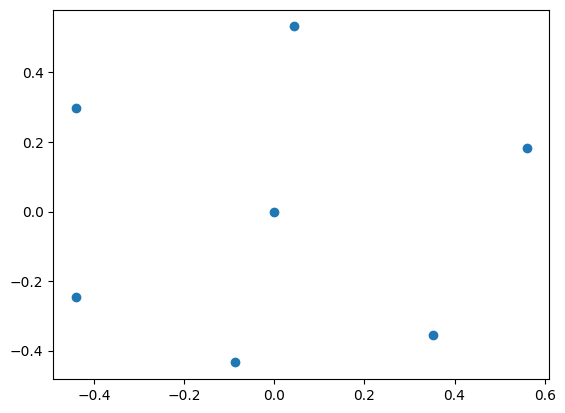

In [82]:
plt.scatter(polygon.coordinates.T[0], polygon.coordinates.T[1])

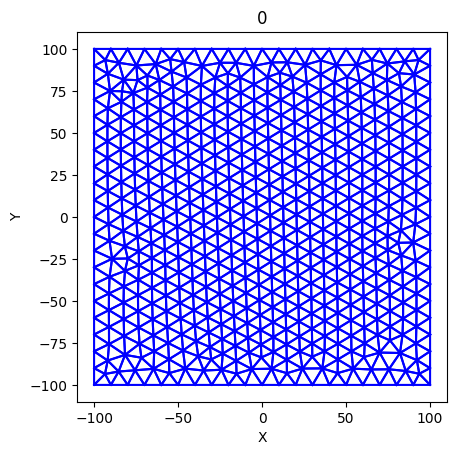

In [83]:
for i in range(num_train_mesh):
    plot_mesh(train_mesh_data_list[i], f"{i}")

In [84]:
def test(device, trial, test_mesh_data_lists):
    model.eval()
    for step, data in enumerate(test_data_loader):
        empty_cache()
        gc.collect()
        # print(f"Step {step + 1}:")
        # print("==========")
        # print(data)
        # print(len(data))
        minibatch = Minibatch()
        minibatch_coordinates = []
        all_edge_index_1 = []
        all_edge_index_2 = []
        batch_list = []
        num_dis = 0
        metric_loss_list = []
        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            # print("polygonID:",polygonID)
            polygon = data_getter(polygonID, trial, test_mesh_data_list, test_polygon_data_list)
            # polygon を正規化する
            polygon = normalization(polygon)
            # print("polygon.coordinates:",polygon.coordinates)
            edge_index = polygon.edge_index + num_dis
            # print("polygon.edge_index:", edge_index)
            all_edge_index_1.append(edge_index[0])
            all_edge_index_2.append(edge_index[1])
            num_dis = num_dis + len(polygon.coordinates)
            # print("==========")
            minibatch_coordinates.append(polygon.coordinates)
            batch_i = torch.tensor([i]*len(polygon.coordinates))
            batch_list.append(batch_i)
            
        # print(minibatch_coordinates)
        minibatch.x = torch.cat(minibatch_coordinates, dim=0)
        
        # print(minibatch.x)
        # print("minibatch.x.size:", minibatch.x.size())
        edge_index_1 = torch.cat(all_edge_index_1, dim=-1)
        edge_index_2 = torch.cat(all_edge_index_2, dim=-1)
        minibatch.edge_index = torch.cat([edge_index_1.unsqueeze(0), edge_index_2.unsqueeze(0)], dim=0)
        # print(minibatch.edge_index)
        # print("minibatch.edge_index.size:", minibatch.edge_index.size())
        minibatch.batch = torch.cat(batch_list, dim=0)
        # print(minibatch.batch)
        # print("minibatch.batch.size:", minibatch.batch.size())

        # すべてのデータをGPU上に移動する
        minibatch.x = minibatch.x.to(device)
        minibatch.edge_index = minibatch.edge_index.to(device)
        minibatch.batch = minibatch.batch.to(device)
        model.to(device)

        out = model(minibatch.x, minibatch.edge_index, minibatch.batch)
        # print("out:", out)
        # print("out:", out.size())

        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            polygon = data_getter(polygonID, trial, test_mesh_data_list, test_polygon_data_list)
            # 正規化する
            polygon = normalization(polygon)

            polygon.coordinates[0] = out[i]
            
            # print("out_i:", out[i])
            polygon = check(polygon, polygonID)
            # print("fixed_out_i:", polygon.coordinates[0])
            # metric_loss = criterion(polygon)
            # metric_loss_list.append(metric_loss)
            
            # 非正規化する
            polygon = denormalization(polygon)

            # 予測したノードの座標をもとのメッシュに当てはめて更新する
            polygon_meshID = int(test_polygon_data_list[polygonID].meshID.split("_")[-1])
            mesh = test_mesh_data_lists[trial][polygon_meshID]

            mesh.coordinates[test_polygon_data_list[polygonID].nodeID[0]] = polygon.coordinates[0]
        
    return test_mesh_data_lists









            

In [85]:
# 100epochで最適化されたメッシュを10個生成する
test_mesh_data_lists = [copy.deepcopy(test_mesh_data_list) for _ in range(10)]

for trial in range(num_trial):
    for epoch in tqdm(range(num_test_epoch)):
        test_mesh_data_lists = test(device, trial, test_mesh_data_lists)


  0%|          | 0/100 [00:06<?, ?it/s]


TypeError: GMSNet.forward() takes 3 positional arguments but 4 were given

In [ ]:
best_mesh_data_list = []
num_test_mesh = len(test_vtk_files)
    
for i in tqdm(range(num_test_mesh)):
    q_hat_list = []
    for j in range(10):
        mesh = test_mesh_data_lists[j][i]

        # q_hat を求めるコード
        q_hat = calculate_q_hat(mesh)
        
        q_hat_list.append(q_hat)
        best = q_hat_list.index(min(q_hat_list))
        best_mesh_data_list.append(test_mesh_data_lists[best + 1][i])
    


    # best_mesh_data_list[i] のデータをvtkファイルで出力する
    vtk_output(best_mesh_data_list[i], f"optimized_{i}")

## 更新したメッシュを表示してみる

In [ ]:
for i in range(num_test_mesh):
    plot_mesh(best_mesh_data_list[i], f"optimized_{i}")

# 元のメッシュから座標が変わっているか確認する

In [ ]:
格子点が滑らかに配置されているか、急激な変化や不連続がないかを評価します。# for i in range(num_test_mesh):
#     print(test_mesh_data_list[i].coordinates.size())
#     print(best_mesh_data_list[i].coordinates.size())


In [ ]:
for i in range(num_test_mesh):
    if torch.equal(test_mesh_data_list[i].coordinates, best_mesh_data_list[i].coordinates):
        print("Not updated!!")
    
    else:
         print("Updated")

In [ ]:
for i in range(num_test_mesh):
    plot_mesh(test_mesh_data_list[i], f"original_{i}")

In [ ]:
a=torch.tensor([[[ 0.6004, -0.1381,  0.5997,  0.2204, -0.5977,  0.4884, -0.1954, -0.2755],
        [-0.5785, -0.7031,  0.2004, -0.1510,  0.2774, -0.5800,  0.5260, -0.5150],
        [-0.1189,  0.1473,  0.3666,  0.5725,  0.6517, -0.5593,  0.1796, -0.3000],
        [-0.0748, -0.5303,  0.6381, -0.5197,  0.3724,  0.2501,  0.2280, -0.3767]],
        [[0.6353,  0.1526,  0.1002, -0.6209,  0.2963, -0.1024, -0.3281,  0.6075],
        [0.1588, -0.3860, -0.3635, -0.0385,  0.3957, -0.1853, -0.4013, -0.2480],
        [-0.5284,  0.2546,  0.5519, -0.6643,  0.1631,  0.3607,  0.1233, -0.2522],
        [0.3676,  0.3681,  0.2616, -0.1182, -0.1916,  0.0747, -0.1194, -0.2073]]])

In [ ]:
a[:,0]

In [ ]:
a.unsqueeze(0)

In [ ]:
import torch

# 3点の座標を定義（これらは微分の対象となる変数なのでrequires_grad=Trueを設定）
p1 = torch.tensor([-0.6721, -0.4008], requires_grad=True)
p2 = torch.tensor([-0.0425,  0.0179], requires_grad=True)
p3 = torch.tensor([-0.3361, -0.1763], requires_grad=True)

# 各辺の長さを計算
a = torch.sqrt(torch.sum((p2 - p1) ** 2))
b = torch.sqrt(torch.sum((p3 - p2) ** 2))
c = torch.sqrt(torch.sum((p1 - p3) ** 2))

# ヘロンの公式を用いて面積を計算
s = (a + b + c) / 2
area = torch.sqrt(s * (s - a) * (s - b) * (s - c))

loss = 1 - (4*torch.sqrt(torch.tensor(3))*area)/(a**2 + b**2 + c**2)

# 面積に対して自動微分を行う
loss.backward()

# 各点に対する勾配を表示
print(p1.grad)
print(p2.grad)
print(p3.grad)

In [ ]:
torch.exp(torch.tensor(0))

In [ ]:
a = [[0.0, 0.0], 
    [-0.3022986352443695, 0.7041022777557373],
    [-0.6732527613639832, 0.49798783659935],
    [-0.6732527613639832, -0.05284641683101654],
    [-0.3600771427154541, -0.19979676604270935],
    [0.1442829966545105, -0.10576343536376953],
    [0.32674723863601685, 0.25243768095970154]]

for i in range(1, len(a)):
    x = [a[0][0], a[i][0]]
    y = [a[0][1], a[i][1]]
    plt.plot(x, y, c="k")
    
for i in range(1, len(a)):
    x = [a[i][0], a[i%6+1][0]]
    y = [a[i][1], a[i%6+1][1]]
    plt.plot(x, y, c="k")
    
plt.scatter([x[0] for x in a], [x[1] for x in a], c="r")

In [ ]:
a = [[-0.08619694411754608, 0.08077329397201538], 
    [-0.3022986352443695, 0.7041022777557373],
    [-0.6732527613639832, 0.49798783659935],
    [-0.6732527613639832, -0.05284641683101654],
    [-0.3600771427154541, -0.19979676604270935],
    [0.1442829966545105, -0.10576343536376953],
    [0.32674723863601685, 0.25243768095970154]]

for i in range(1, len(a)):
    x = [a[0][0], a[i][0]]
    y = [a[0][1], a[i][1]]
    plt.plot(x, y, c="k")
    
for i in range(1, len(a)):
    x = [a[i][0], a[i%6+1][0]]
    y = [a[i][1], a[i%6+1][1]]
    plt.plot(x, y, c="k")
    
plt.scatter([x[0] for x in a], [x[1] for x in a], c="r")